# Projet de Calculs de Réacteurs - GCH3130 Été 2022

Par:
- Alexandre Sévigny
- Symphorien Notue
- Guillaume Majeau-Bettez

Le but est d'ajuster les paramètres d'opération d'un procédé de vaporeformage de méthane pour en optimiser le rendement en hydrogène, dans un contexte d'électrification et de décarbonisation partielle du procédé.

## On importe la classe SteamMethaneReformer et on initialise les données

In [1]:
from steam_methane_reformer import SteamMethaneReformer, savefig
import numpy as np
from matplotlib import pyplot as plt

In [2]:
data_path='data.xlsx'
F0_tot = 7381 / (7 * 48)

## On définit un cas de base pour notre Steam Methane Rerformer 

In [3]:
# EXPÉRIENCE DE BASE

# Initialiser l'objet avec les données de base
smr_base = SteamMethaneReformer(data_path)

# résoudre notre système avec les paramètres d'opération de base
smr_base.solve(F0_tot=F0_tot,
               P0_tot=30,
               T0=604 + 273,
               Ta=800 + 273
               )

Tout est beau!


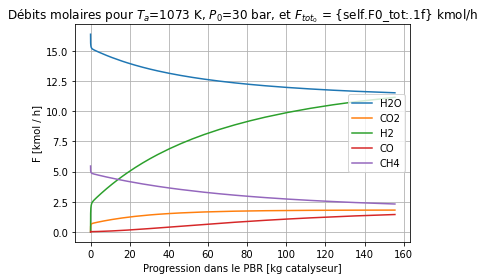

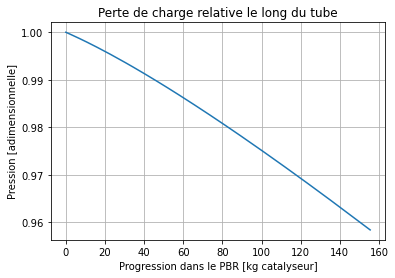

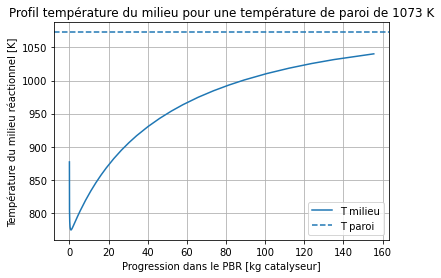

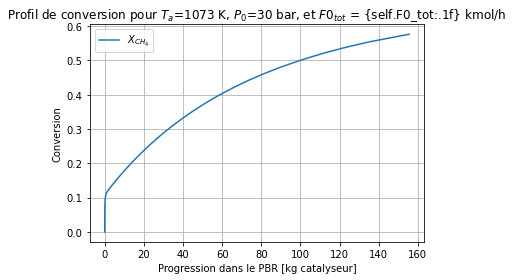

In [4]:
smr_base.plot('base', what='all')

In [5]:
# Enregistrer le débit de production d'hydrogène du cas de base
FH2_base = smr_base.F['H2']

On voit que le rendement est relativement faible!

## On joue avec les paramètres d'entrée

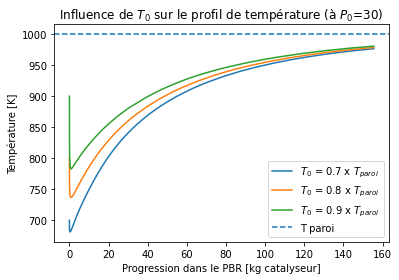

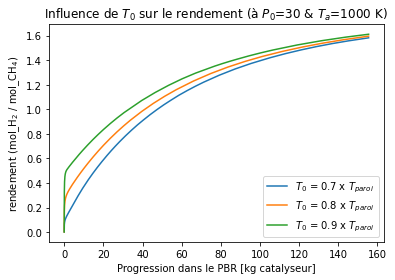

In [6]:
# COMPRENDRE L'INFLUENCE DE LA TEMPÉRATURE D'ENTRÉE

# Testons diverses fractions de la température des parois
T0_range = np.arange(0.7, 0.9, 0.1)


smr = SteamMethaneReformer(data_path)
Ta = 1000
P0_tot = 30
rendements = []
for T0_ratio in T0_range:
    T0 = T0_ratio * Ta
    smr.solve(F0_tot, P0_tot, T0, Ta, verbose=False)
    rendements.append((smr.sol.t, smr.rendement))
    
    # visualiser
    plt.plot(smr.sol.t, smr.y_out['T'], label=f"$T_0$ = {T0_ratio:.1f} x $T_{{paroi}}$")
plt.axhline(Ta, linestyle='dashed', label='T paroi')
plt.legend()
plt.xlabel('Progression dans le PBR [kg catalyseur]')
plt.ylabel("Température [K]")
plt.title(f"Influence de $T_0$ sur le profil de température (à $P_0$={P0_tot})")
savefig('exploration_T0')
plt.show()


for i, T0_ratio in enumerate(T0_range):
    plt.plot(rendements[i][0], rendements[i][1], label=f"$T_0$ = {T0_ratio:.1f} x $T_{{paroi}}$")
plt.xlabel('Progression dans le PBR [kg catalyseur]')
plt.ylabel("rendement (mol_H$_2$ / mol_CH$_4$)")
plt.title(f"Influence de $T_0$ sur le rendement (à $P_0$={P0_tot} & $T_a$={Ta} K)")
plt.legend()
savefig('exploration_T0_rendement')
plt.show()

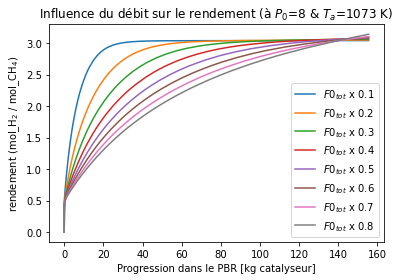

In [7]:
# COMPRENDRE L'EFFET DU DÉBIT MOLAIRE ENTRANT

Ta=800 + 273
P0_tot = 8
T0 = Ta * 0.8
for F0_tot_ratio in np.arange(0.1, 0.9, 0.1):
    smr.solve(F0_tot * F0_tot_ratio, P0_tot, T0, Ta, verbose=False)
    plt.plot(smr.sol.t, smr.rendement, label=f"$F0_{{tot}}$ x {F0_tot_ratio:.1f}")
plt.xlabel('Progression dans le PBR [kg catalyseur]')
plt.ylabel("rendement (mol_H$_2$ / mol_CH$_4$)")
plt.title(f"Influence du débit sur le rendement (à $P_0$={P0_tot} & $T_a$={Ta} K)")
plt.legend()
savefig('exploration_P0tot_rendement')
plt.show()

On voit que T0 n'a à peu près pas d'influence, tant que le temps de résidence est suffisant pour que l'équilibre thermique soit atteint avant la fin du PBR. Même jeu pour le débit: ce qui importe c'est que celui-ci soit suffisamment lent pour que l'équilibre chimique soit atteint avant la fin du réacteur; au-delà de ça, c'est sans effet.

## Exploration des Pressions et Températures d'opération

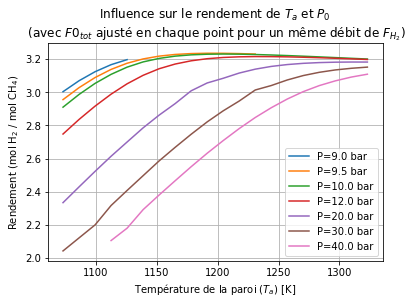

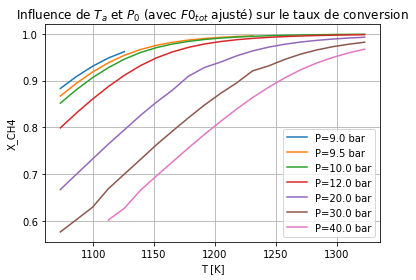

In [8]:
# EXPLORATION DES OPTIONS
smr = SteamMethaneReformer(data_path)

# Spectre de températures à évaluer
Ta_min = 800 + 273
Ta_max = 1050 + 273
Ta_range = np.linspace(Ta_min, Ta_max, 20)

# Pressions à évaluer
P0_range = [ 8.5, 9, 9.5,  10, 12, 20, 30, 40]

# Évaluation de toutes les combinaisons
pt_rendements, pt_conversions = smr.explore_all_options(smr_base.T0, Ta_range, P0_range, F0_tot, FH2_base)


## Analyse de paramètres "optimaux"

À partir des graphiques précédent, on décide d'opérer à 1200 K, et une pression initiale de 9.5 bar, avec un débit d'entrée ajusté automatiquement 

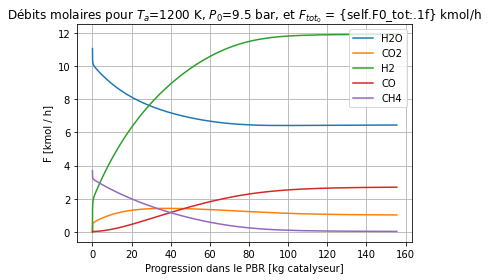

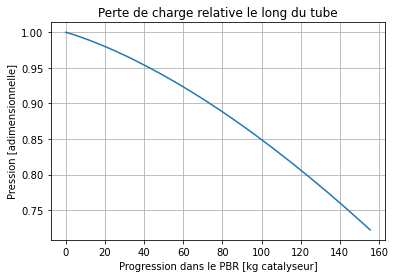

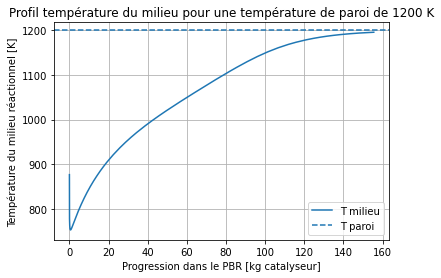

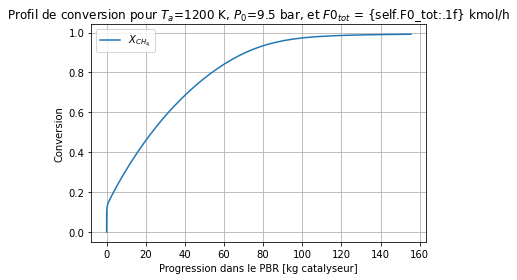

In [9]:
smr_best = SteamMethaneReformer(data_path)
Ta = 1200
T0=604 + 273
P0 = 9.5
smr_best.solve_and_adjustF0(F0_tot, P0, T0, Ta, FH2_base=FH2_base, verbose=False)
smr_best.plot('optimal_')

In [10]:
# Les débits finaux
smr_best.F

H2O     6.446604
CO2     1.024433
H2     11.920388
CO      2.698414
CH4     0.031163
Name: 189, dtype: float64

## Visualisations contrastées du cas de base et du cas final

In [ ]:
figname_prefix='beforeAfter_'
fig = plt.figure()
ax = plt.axes()

for i in smr_base.ix.subst:
    color = next(ax._get_lines.prop_cycler)['color']
    ax.plot(smr_base.sol.t, smr_base.y_out[i], color=color,  linestyle='dashed', alpha=0.5)
    ax.plot(smr_best.sol.t, smr_best.y_out[i], color=color, label=i)
ax.plot([], [], color='black', linestyle='dashed', label="cas de base")
plt.legend(loc="upper center", ncol=3)
plt.title(f"Débits molaires de la reconfiguration \n ($T_a$={smr_best.Ta} K, $P_0$={smr_best.P0_tot} bar,"
          " et $F_{{tot_0}}$ = {smr_best.F0_tot:.1f} kmol/h \n contrasté au cas de base")
plt.xlabel('Progression dans le PBR [kg catalyseur]')
plt.ylabel('F [kmol / h]')
plt.grid()
for form in ['.pdf', '.svg']:
    plt.savefig(figname_prefix + 'debitsMolaires' + form, bbox_inches='tight')
plt.show()

In [ ]:
# COMPARER LES PERTES DE CHARGES ET LES CONVERSIONS DU CAS DE BASE ET FINAL DANS UN SEUL GRAPHIQUE

# Préparer la figure
fig = plt.figure()
ax = plt.axes()
ax.set_ylim([0, 1.2])
ax2 = ax.twinx()
ax2.set_ylim([0, 1.2])

# Axes, titres et étiquettes, avec des couleurs distinctes
ax.spines['left'].set_color('blue')
ax.tick_params(axis='y', colors='blue')
ax2.spines['right'].set_color('red')
ax2.tick_params(axis='y', colors='red')
plt.title("Évolution de la perte de charge et de la conversion")
ax.set_xlabel('Progression dans le PBR [kg catalyseur]')
ax.set_ylabel('Pression normalisée', color='blue')
ax2.set_ylabel('Conversion $X_{CH_4}$', color='red')
plt.grid()

# Illustrer le cas de base
ax.plot(smr_base.sol.t, smr_base.y_out['p'], color='blue', linestyle='dashed', alpha=0.6)
ax2.plot(smr_base.sol.t, smr_base.X, color='red', linestyle='dashed', alpha=0.6)

# Illustrer le cas optimisé
l1 = ax.plot(smr_best.sol.t, smr_best.y_out['p'], label='pression', color='blue' )
l2 = ax2.plot(smr_best.sol.t, smr_best.X, label="conversion", color='red')
l3 = ax2.plot([], [], color='black', linestyle='dashed', label='cas de base')

# Position des légendes
ax2.legend(loc="lower right")
ax.legend(loc="upper left")

savefig(figname_prefix + 'perteDeCharge')
plt.show()

In [ ]:
# COMPARAISON DES PROFILS DE TEMPÉRATURES DU CAS DE BASE ET OPTIMISÉ

plt.title("Profils de températures du milieu réactionnel")
plt.plot(smr_base.sol.t, smr_base.y_out['T'], label='T milieu, cas de base', 
         color='blue', linestyle='dashed', alpha=0.6)
plt.axhline(smr_base.Ta, linestyle='dashed', color='black', 
            label='T paroi, cas de base', alpha=0.6)

plt.plot(smr_best.sol.t, smr_best.y_out['T'], label='T milieu', color='blue')
plt.axhline(smr_best.Ta, color='black', label='T paroi')

plt.legend()
plt.grid()
plt.ylabel('Température [K]')
plt.xlabel('Progression dans le PBR [kg catalyseur]')
savefig(figname_prefix + 'profilDeTempérature')
plt.show()

## Comparaison des rendements finaux du cas de base et du cas optimisé

In [ ]:
smr_base.rendement_fin

In [ ]:
smr_best.rendement_fin

smr_best.rendement_fin

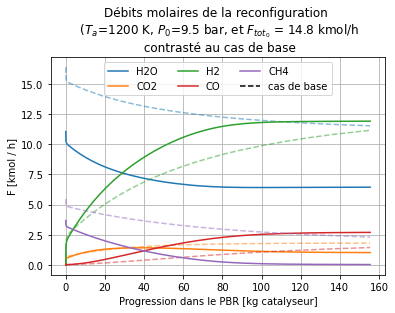

In [11]:
figname_prefix='beforeAfter_'
fig = plt.figure()
ax = plt.axes()

for i in smr_base.ix.subst:
    color = next(ax._get_lines.prop_cycler)['color']
    ax.plot(smr_base.sol.t, smr_base.y_out[i], color=color,  linestyle='dashed', alpha=0.5)
    ax.plot(smr_best.sol.t, smr_best.y_out[i], color=color, label=i)
ax.plot([], [], color='black', linestyle='dashed', label="cas de base")
plt.legend(loc="upper center", ncol=3)
plt.title(f"Débits molaires de la reconfiguration \n ($T_a$={smr_best.Ta} K, $P_0$={smr_best.P0_tot} bar,"
          " et $F_{{tot_0}}$ = {smr_best.F0_tot:.1f} kmol/h \n contrasté au cas de base")
plt.xlabel('Progression dans le PBR [kg catalyseur]')
plt.ylabel('F [kmol / h]')
plt.grid()
for form in ['.pdf', '.svg']:
    plt.savefig(figname_prefix + 'debitsMolaires' + form, bbox_inches='tight')
plt.show()

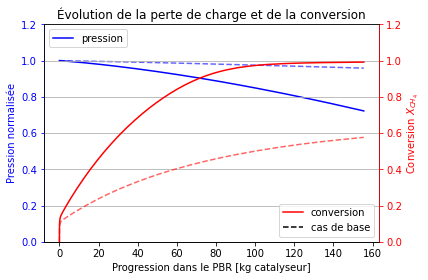

In [12]:
# COMPARER LES PERTES DE CHARGES ET LES CONVERSIONS DU CAS DE BASE ET FINAL DANS UN SEUL GRAPHIQUE

# Préparer la figure
fig = plt.figure()
ax = plt.axes()
ax.set_ylim([0, 1.2])
ax2 = ax.twinx()
ax2.set_ylim([0, 1.2])

# Axes, titres et étiquettes, avec des couleurs distinctes
ax.spines['left'].set_color('blue')
ax.tick_params(axis='y', colors='blue')
ax2.spines['right'].set_color('red')
ax2.tick_params(axis='y', colors='red')
plt.title("Évolution de la perte de charge et de la conversion")
ax.set_xlabel('Progression dans le PBR [kg catalyseur]')
ax.set_ylabel('Pression normalisée', color='blue')
ax2.set_ylabel('Conversion $X_{CH_4}$', color='red')
plt.grid()

# Illustrer le cas de base
ax.plot(smr_base.sol.t, smr_base.y_out['p'], color='blue', linestyle='dashed', alpha=0.6)
ax2.plot(smr_base.sol.t, smr_base.X, color='red', linestyle='dashed', alpha=0.6)

# Illustrer le cas optimisé
l1 = ax.plot(smr_best.sol.t, smr_best.y_out['p'], label='pression', color='blue' )
l2 = ax2.plot(smr_best.sol.t, smr_best.X, label="conversion", color='red')
l3 = ax2.plot([], [], color='black', linestyle='dashed', label='cas de base')

# Position des légendes
ax2.legend(loc="lower right")
ax.legend(loc="upper left")

savefig(figname_prefix + 'perteDeCharge')
plt.show()

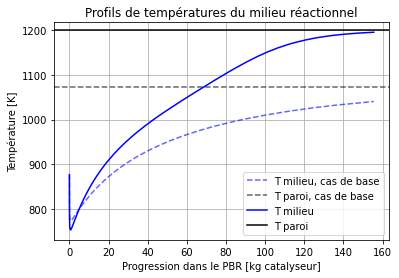

In [13]:
# COMPARAISON DES PROFILS DE TEMPÉRATURES DU CAS DE BASE ET OPTIMISÉ

plt.title("Profils de températures du milieu réactionnel")
plt.plot(smr_base.sol.t, smr_base.y_out['T'], label='T milieu, cas de base', 
         color='blue', linestyle='dashed', alpha=0.6)
plt.axhline(smr_base.Ta, linestyle='dashed', color='black', 
            label='T paroi, cas de base', alpha=0.6)

plt.plot(smr_best.sol.t, smr_best.y_out['T'], label='T milieu', color='blue')
plt.axhline(smr_best.Ta, color='black', label='T paroi')

plt.legend()
plt.grid()
plt.ylabel('Température [K]')
plt.xlabel('Progression dans le PBR [kg catalyseur]')
savefig(figname_prefix + 'profilDeTempérature')
plt.show()

## Comparaison des rendements finaux du cas de base et du cas optimisé

In [14]:
smr_base.rendement_fin

2.0430971559890994

In [15]:
smr_best.rendement_fin

3.2353831568032887